In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import random
import math


In [194]:
bike = pd.read_csv("bike_rental_hour.csv")

Some EDA first

In [195]:
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

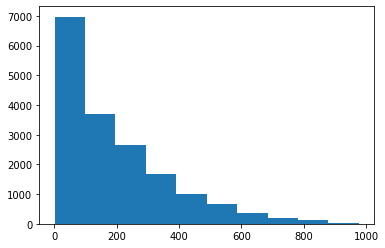

In [196]:
%matplotlib inline
plt.hist(bike['cnt'])

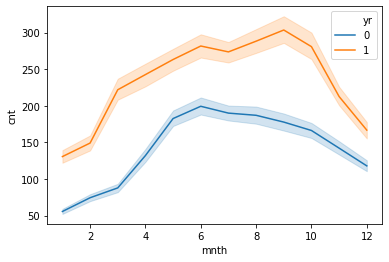

In [302]:
sns.lineplot(x = bike['mnth'], y = bike["cnt"], hue = bike["yr"])

Let's group hours into morning, afternoon, evening and before dawn ...

In [197]:
def assign_label(hour):
    if 6<hour<=12:
        return 1
    elif 12 < hour <= 18:
        return 2
    elif 18< hour <= 24:
        return 3
    else:
        return 4

In [304]:
bike["time_label"] = bike["hr"].apply(assign_label)

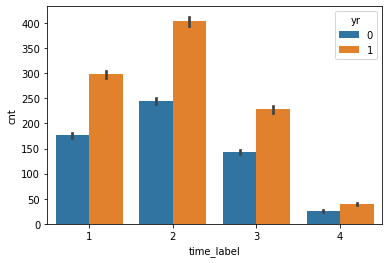

In [307]:
sns.barplot(x = bike['time_label'], y = bike["cnt"], hue = bike["yr"])

In [199]:
cor_df = bike.corr()

In [200]:
cnt_corr = abs(cor_df["cnt"]).sort_values(ascending = False)

In [201]:
cnt_corr

cnt           1.000000
registered    0.972151
casual        0.694564
time_label    0.494422
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

Splitting the data into training and test sets (80/20)

In [202]:
bike.shape[0] * 0.8

13903.2

In [203]:
random.seed(1)
bike = bike.reindex(np.random.permutation(bike.shape[0]))

In [204]:
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
13881,13882,2012-08-06,3,1,8,14,0,1,1,1,0.82,0.7576,0.46,0.0000,99,188,287,2
8099,8100,2011-12-09,4,0,12,3,0,5,1,1,0.22,0.2727,0.80,0.0000,1,5,6,4
11195,11196,2012-04-16,2,1,4,16,1,1,0,1,0.80,0.6970,0.33,0.4627,92,266,358,2
9202,9203,2012-01-24,1,1,1,8,0,2,1,2,0.32,0.3333,0.93,0.1343,11,479,490,1
12650,12651,2012-06-16,2,1,6,7,0,6,0,1,0.54,0.5152,0.68,0.1940,10,68,78,1


In [205]:
train = bike.iloc[0:13903,]
test = bike.iloc[13903:,]

Now we perform some basic variable selection and cleaning

In [206]:
## remove variables that have corr <0.05

columns = cnt_corr[cnt_corr > 0.05].index

## remove cnt, casual, registered, instant

columns = columns.drop(["cnt", "registered", "casual", "instant"])

## remove temp as we have atemp, also removing hr since we grouped them

columns = columns.drop(["temp", "hr"])


In [207]:
columns

Index(['time_label', 'atemp', 'hum', 'yr', 'season', 'weathersit', 'mnth',
       'windspeed'],
      dtype='object')

Now let's run a basic regression

In [208]:
model1 = LinearRegression()
model1.fit(train[columns], train["cnt"])
prediction1 = model1.predict(test[columns])
rme1 = math.sqrt(mean_squared_error(test["cnt"], prediction1))

In [209]:
rme = {}
prediction = {}
rme["LinearReg"] = rme1
prediction["True"] = test["cnt"]
prediction["LinearReg"] = prediction1

In [210]:
test.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
7518,7519,2011-11-14,4,0,11,21,0,1,1,1,0.60,0.6212,0.53,0.3582,37,176,213,3
15080,15081,2012-09-25,4,1,9,13,0,2,1,1,0.64,0.6212,0.47,0.2537,48,257,305,2
6930,6931,2011-10-21,4,0,10,9,0,5,1,2,0.42,0.4242,0.58,0.1343,33,189,222,1
17343,17344,2012-12-30,1,1,12,12,0,0,0,1,0.28,0.2273,0.36,0.5821,47,97,144,1
11575,11576,2012-05-02,2,1,5,12,0,3,1,2,0.58,0.5455,0.83,0.2239,35,210,245,1


Next, we will use dummies for categorical variables, and see if we can have some improvements

In [211]:
cate = ["time_label", "yr", "season", "weathersit", "mnth"]

In [212]:
train_cate = train.copy()
test_cate = test.copy()

In [213]:
train_dummies = pd.get_dummies(train_cate, prefix = cate, columns = cate)
test_dummies = pd.get_dummies(test_cate, prefix = cate, columns = cate)


    

In [214]:
columns_cate = train_dummies.columns

In [215]:
columns_cate = columns_cate.drop(["instant", "dteday", "hr", "holiday", "weekday", "workingday", "temp", "casual", "registered", "cnt", "weathersit_4"])


In [216]:
columns_cate

Index(['atemp', 'hum', 'windspeed', 'time_label_1', 'time_label_2',
       'time_label_3', 'time_label_4', 'yr_0', 'yr_1', 'season_1', 'season_2',
       'season_3', 'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7',
       'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12'],
      dtype='object')

Now, we fit a second regression with dummies

In [217]:
model2 = LinearRegression()
model2.fit(train_dummies[columns_cate], train_dummies["cnt"])
prediction2 = model2.predict(test_dummies[columns_cate])

In [218]:
test.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
7518,7519,2011-11-14,4,0,11,21,0,1,1,1,0.60,0.6212,0.53,0.3582,37,176,213,3
15080,15081,2012-09-25,4,1,9,13,0,2,1,1,0.64,0.6212,0.47,0.2537,48,257,305,2
6930,6931,2011-10-21,4,0,10,9,0,5,1,2,0.42,0.4242,0.58,0.1343,33,189,222,1
17343,17344,2012-12-30,1,1,12,12,0,0,0,1,0.28,0.2273,0.36,0.5821,47,97,144,1
11575,11576,2012-05-02,2,1,5,12,0,3,1,2,0.58,0.5455,0.83,0.2239,35,210,245,1


In [219]:
rme2 = math.sqrt(mean_squared_error(test["cnt"], prediction2))

In [220]:
rme["Regression_with_dummies"] = rme2
prediction["Regression_with_dummies"] = prediction2

Next, I would like to see if any numerical variables need any transformation

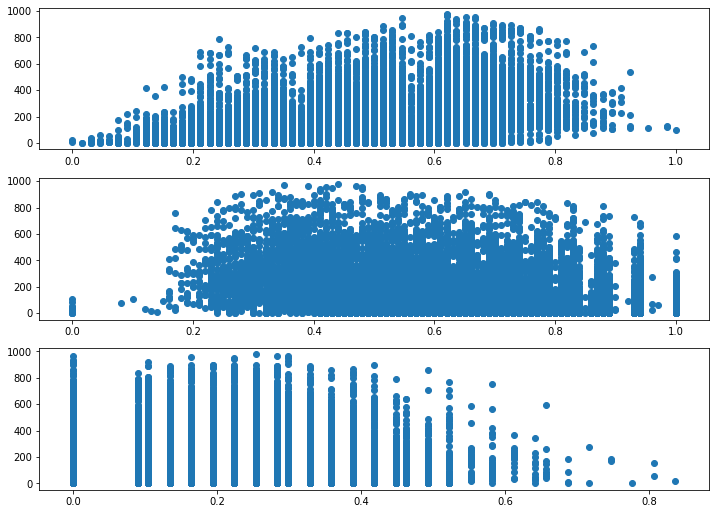

In [221]:
## plot y vs numerical variables

fig = plt.figure(figsize = (12,12))
axe1 = fig.add_subplot(4,1,1)
axe2 = fig.add_subplot(4,1,2)
axe3 = fig.add_subplot(4,1,3)
axe1.scatter(train["atemp"], train["cnt"])
axe2.scatter(train["hum"], train["cnt"])
axe3.scatter(train["windspeed"], train["cnt"])



(array([5567., 2966., 2140., 1318.,  790.,  530.,  291.,  154.,  117.,
          30.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

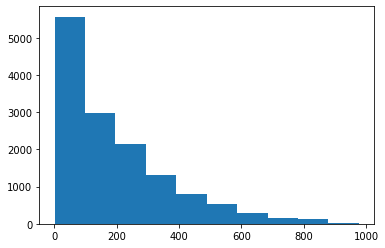

In [310]:
plt.hist(train["cnt"])


(array([ 131.,  351.,  747.,  821., 1032., 1258., 2021., 3411., 3022.,
        1109.]),
 array([0.        , 0.68844867, 1.37689733, 2.065346  , 2.75379466,
        3.44224333, 4.13069199, 4.81914066, 5.50758932, 6.19603799,
        6.88448665]),
 <a list of 10 Patch objects>)

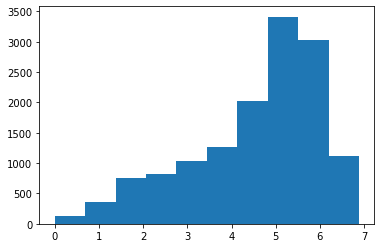

In [311]:
plt.hist(np.log(train["cnt"]))

There seems to be no need to transform x, but y seems to be very skewed, and log it should help

In [224]:
train_dummies["log_cnt"] = np.log(train_dummies["cnt"])
test_dummies["log_cnt"] = np.log(test_dummies["cnt"])

In [225]:
# fit on log_cnt, and exponentiate predictions 

model3 = LinearRegression()
model3.fit(train_dummies[columns_cate], train_dummies["log_cnt"])
pred = model3.predict(test_dummies[columns_cate])
prediction3 = np.exp(pred)

In [226]:
rme["Regression_log_cnt"] = math.sqrt(mean_squared_error(test["cnt"], prediction3))
prediction["Regression_log_cnt"] = prediction3

In [227]:
rme

{'LinearReg': 131.36931469548472,
 'Regression_with_dummies': 119.64630295503792,
 'Regression_log_cnt': 120.11659336066317}

Log(y) seems like not a huge improvement, so now we can try trees

In [228]:
model4 = DecisionTreeRegressor()
model4.fit(train[columns], train["cnt"])
prediction4 = model4.predict(test[columns])

In [229]:
rme["Full_tree"] = math.sqrt(mean_squared_error(test["cnt"], prediction4))
prediction["Full_tree"] = prediction4


In [230]:
## check if it's overfitting (training error vs testing error)
train_pred = model4.predict(train[columns])
train_rme = math.sqrt(mean_squared_error(train["cnt"], train_pred))


In [231]:
print("training rme is " + str(train_rme))
print("testing rme is " + str(rme["Full_tree"]))

training rme is 22.160314289889346
testing rme is 146.14166408566376


It's clearly overfitting, so let's try to tune the model so it performs better on test set

In [232]:
def gridsearch(min_samples_leaf, max_depth):
    model = DecisionTreeRegressor(max_depth = max_depth, min_samples_leaf = min_samples_leaf)
    model.fit(train[columns], train["cnt"])
    test_pred = model.predict(test[columns])
    test_rme = math.sqrt(mean_squared_error(test["cnt"], test_pred))

### check training and testing error again
    train_pred = model.predict(train[columns])
    train_rme = math.sqrt(mean_squared_error(train["cnt"], train_pred))

    print( "min samples = " + str(min_samples_leaf) + ", max depth = " +str(max_depth) +", training rme is " + str(round(train_rme,2)) + ", testing rme is " + str(round(test_rme,2)))

    

In [233]:
for i in range(20, 200, 30):
    for j in range (5, 30, 5):
        gridsearch(min_samples_leaf = i, max_depth = j)

min samples = 20, max depth = 5, training rme is 117.75, testing rme is 117.36
min samples = 20, max depth = 10, training rme is 106.52, testing rme is 112.17
min samples = 20, max depth = 15, training rme is 103.36, testing rme is 113.0
min samples = 20, max depth = 20, training rme is 103.01, testing rme is 113.01
min samples = 20, max depth = 25, training rme is 103.01, testing rme is 113.01
min samples = 50, max depth = 5, training rme is 117.75, testing rme is 117.36
min samples = 50, max depth = 10, training rme is 109.0, testing rme is 112.41
min samples = 50, max depth = 15, training rme is 108.31, testing rme is 112.5
min samples = 50, max depth = 20, training rme is 108.31, testing rme is 112.5
min samples = 50, max depth = 25, training rme is 108.31, testing rme is 112.5
min samples = 80, max depth = 5, training rme is 117.75, testing rme is 117.37
min samples = 80, max depth = 10, training rme is 110.65, testing rme is 112.88
min samples = 80, max depth = 15, training rme i

It seems like best value is min samples per leaf = 50, and max depth of the tree is 15, so let's do that

In [234]:
model5 = DecisionTreeRegressor(max_depth = 15, min_samples_leaf = 50)
model5.fit(train[columns], train["cnt"])
prediction5 = model5.predict(test[columns])
rme ["Tuned_tree"] = math.sqrt(mean_squared_error(test["cnt"], prediction5))
prediction["Tuned_tree"] = prediction5

Next, let's try random forest!

In [235]:
model6 = RandomForestRegressor(n_estimators = 2000, max_depth = 15, min_samples_leaf = 50)
model6.fit(train[columns], train["cnt"])
prediction6 = model6.predict(test[columns])
rme ["random_forest"] = math.sqrt(mean_squared_error(test["cnt"], prediction6))
prediction["random_forest"] = prediction6


In [236]:
rme

{'LinearReg': 131.36931469548472,
 'Regression_with_dummies': 119.64630295503792,
 'Regression_log_cnt': 120.11659336066317,
 'Full_tree': 146.14166408566376,
 'Tuned_tree': 112.50164666774883,
 'random_forest': 110.721216819472}

In [237]:
# check if random forest is overfitting

train_pred = model6.predict(train[columns])
train_rme = math.sqrt(mean_squared_error(train["cnt"], train_pred))

train_rme


108.20724593499122

We are done! We will use the predictions given by random forest (prediction6). Finally, let's calculate the mean absolute error to see how much we are off on average!

In [238]:
print(round(mean_absolute_error(test["cnt"], prediction["random_forest"]),2))

78.96


In [239]:
test.reset_index(inplace = True)


In [308]:
report = pd.concat([test, round(pd.DataFrame(prediction["random_forest"]))], axis = 1)
report.rename(columns = {0: "prediction"}, inplace = True)
report.head()

,index,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label,prediction
0,7518,7519,2011-11-14,4,0,11,21,0,1,1,1,0.60,0.6212,0.53,0.3582,37,176,213,3,231.0
1,15080,15081,2012-09-25,4,1,9,13,0,2,1,1,0.64,0.6212,0.47,0.2537,48,257,305,2,596.0
2,6930,6931,2011-10-21,4,0,10,9,0,5,1,2,0.42,0.4242,0.58,0.1343,33,189,222,1,209.0
3,17343,17344,2012-12-30,1,1,12,12,0,0,0,1,0.28,0.2273,0.36,0.5821,47,97,144,1,156.0
4,11575,11576,2012-05-02,2,1,5,12,0,3,1,2,0.58,0.5455,0.83,0.2239,35,210,245,1,295.0


Visualizations to figure out where our predictions are not accurate

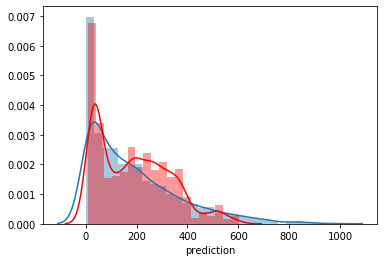

In [291]:
g = sns.distplot(report["cnt"])
g= sns.distplot(report["prediction"], color = "r")

It seems like our prediction is over-predicting in the middle range (50-200), and under-predicting toward the higher range(400-800). We can further group the data by variables to see if we can discover additional pattern.

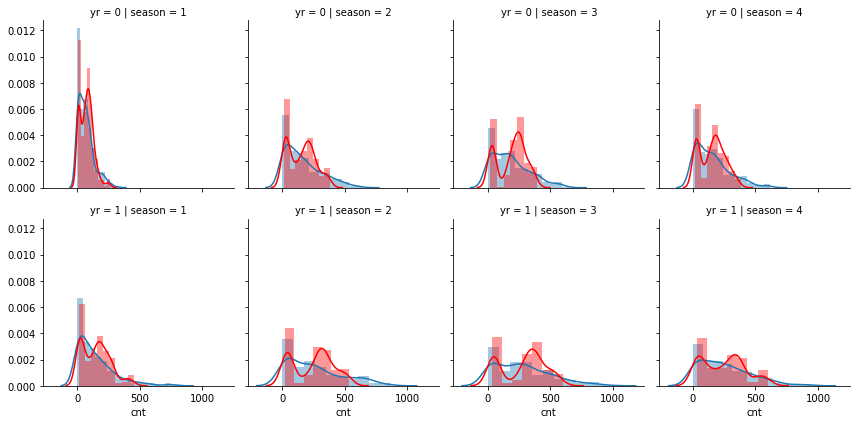

In [297]:
g= sns.FacetGrid(report, col = "season", row = "yr")
g= g.map(sns.distplot, "cnt")
g = g.map(sns.distplot, "prediction", color = "red")
g= g.set_xlabels("cnt")



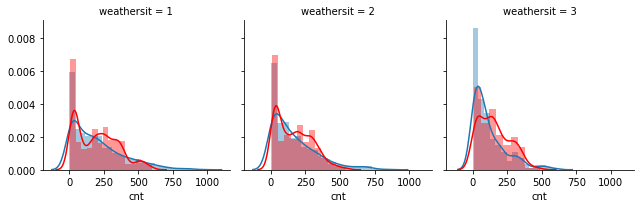

In [298]:
g= sns.FacetGrid(report, col = "weathersit")
g= g.map(sns.distplot, "cnt")
g = g.map(sns.distplot, "prediction", color = "red")
g= g.set_xlabels("cnt")

It seems like the problem is mostly with season 3 and wheathersit 3, where our prediction is clearly overshooting. 